# PyDMD

## Tutorial 2: Advanced use of Dynamic Mode Decomposition

In this tutorial we will show a more sophisticated application of the standard **dynamic mode decomposition** algorithm. In detail, we will create a 2D dataset that oscillates in time and we will focus on the parameters that allow to optimally tune this technique for the studied system. Since the main goal of this tutorial is the introduction of the advance settings, we recommend to read first the [basic tutorial](https://github.com/mathLab/PyDMD/blob/master/tutorials/tutorial-1-dmd.ipynb).

First of all we import the DMD class from the pydmd package, we set matplotlib for the notebook, we import numpy and scipy, the function to show HTML videos on IPython and finally we import the animation submodule from matplotlib.

In [1]:
%matplotlib inline
import numpy as np
import scipy
import scipy.integrate

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
from pydmd import DMD

Now, we create the dataset: a hyperbolic sine with damped oscillations is obtained from the following formula:
- $f(x,y,t) := \text{senh}(x) * \text{senh}(y)*1.2\text{i}^{-t}$.


We take 16 equispaced snapshots.

Moreover, to make the input data more realistic, we add some noise.

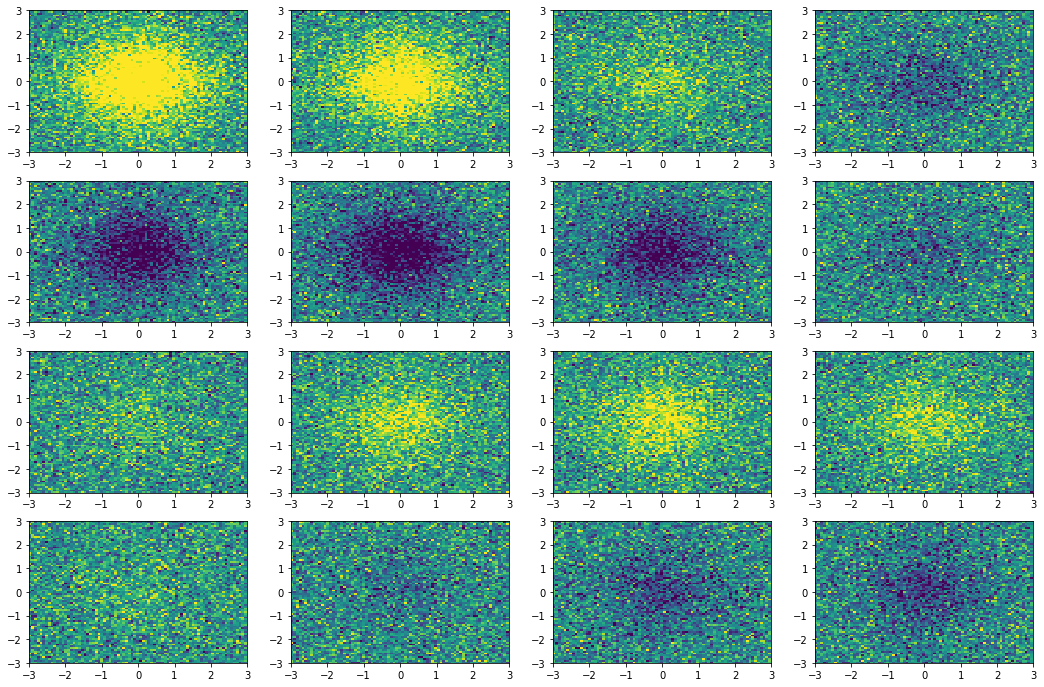

In [2]:
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

time = np.linspace(0, 6, 16)

data = [2/np.cosh(x1grid)/np.cosh(x2grid)*(1.2j**-t) for t in time]
noise = [np.random.normal(0.0, 0.4, size=x1grid.shape) for t in time]

snapshots = [d+n for d,n in zip(data, noise)]

fig = plt.figure(figsize=(18,12))
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.real, vmin=-1, vmax=1)

Alright, now it's time to apply the DMD to the collected data. First, we create a new `DMD` instance; we note there are three optional parameters:
- `svd_rank`: since the dynamic mode decomposition relies on *singular value decomposition*, we can specify the number of the largest singular values used to approximate the input data.
- `tlsq_rank`: using the total least square, it is possible to perform a linear regression in order to remove the noise on the data; because this regression is based again on the singular value decomposition, this parameter indicates how many singular values are used.
- `exact`: boolean flag that allows to chose between the exact modes or the projected one.

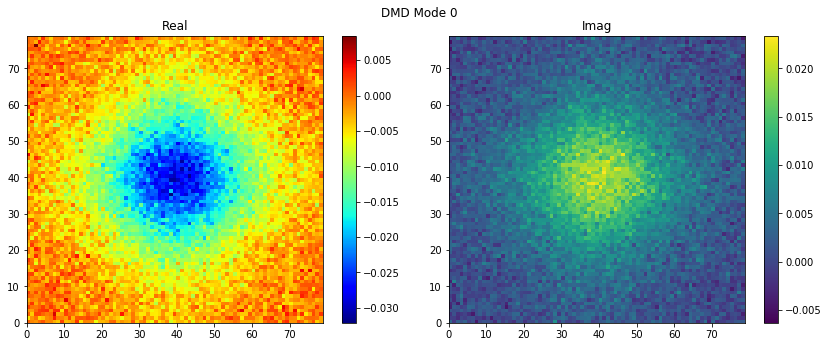

In [3]:
dmd = DMD(svd_rank=1, tlsq_rank=2, exact=True)
dmd.fit(snapshots)
dmd.plot_modes_2D(figsize=(12,5))

The `svd_rank` can be set to zero for an automatic selection of the truncation rank; in some cases (as this tutorial) the singular values should be examinated in order to select the proper truncation.

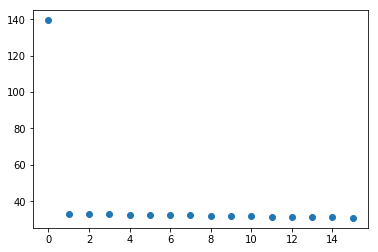

In [4]:
fig = plt.plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T), 'o')

We can now plot the reconstructed states from DMD: the approximated system is similar to the original one and, moreover, the noise is greatly reduced.

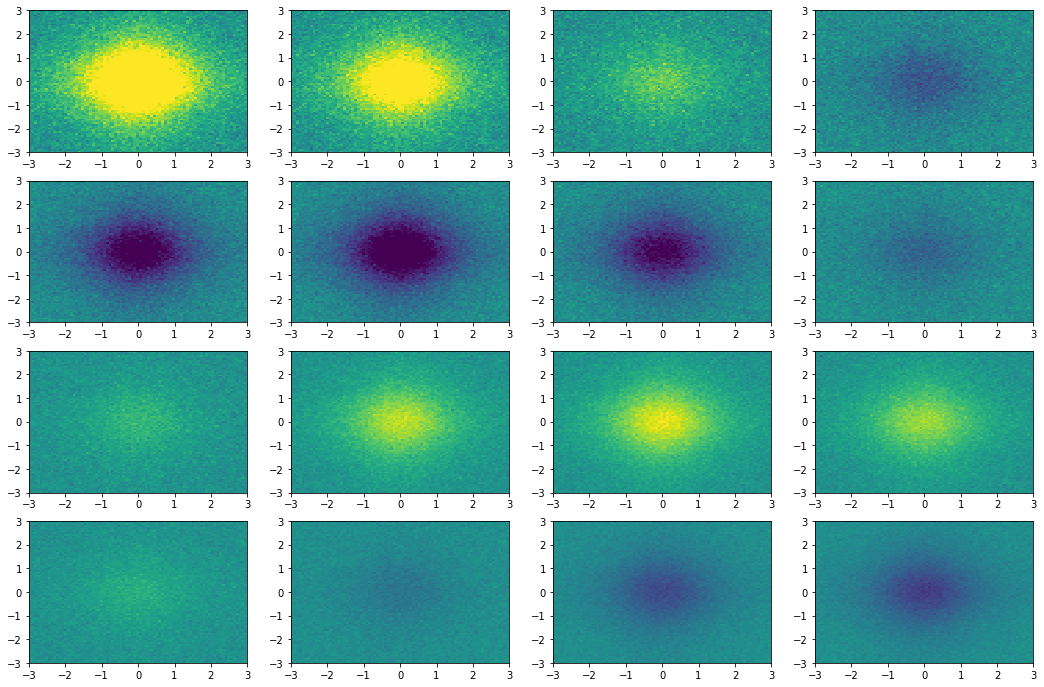

In [5]:
fig = plt.figure(figsize=(18,12))
for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T, start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.reshape(x1grid.shape).real, vmin=-1, vmax=1)

We can also manipulate the interval between the approximated states and extend the temporal window where the data is reconstructed thanks to DMD. Let's make the DMD delta time a quarter of the original and extend the temporal window to $[0, 3t_{\text{org}}]$, where $t_{\text{org}}$ indicates the time when the last snapshot was caught.

In [6]:
print("Shape before manipulation: {}".format(dmd.reconstructed_data.shape))
dmd.dmd_time['dt'] *= .25
dmd.dmd_time['tend'] *= 3
print("Shape after manipulation: {}".format(dmd.reconstructed_data.shape))

Shape before manipulation: (6400, 16)
Shape after manipulation: (6400, 181)


Now the cool trick: we combine the reconstructed dataset to create an animation that shows the evolution of our system.

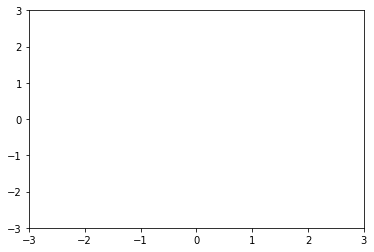

In [7]:
fig = plt.figure()

dmd_states = [state.reshape(x1grid.shape) for state in dmd.reconstructed_data.T]

frames = [
    [plt.pcolor(x1grid, x2grid, state.real, vmin=-1, vmax=1)]
    for state in dmd_states
]

ani = animation.ArtistAnimation(fig, frames, interval=70, blit=False, repeat=False)

HTML(ani.to_html5_video())

Amazing, isn't it? And we remember that everything is obtained just from few noisy snapshots. For a further check about the accuracy of the reconstruction, we can plot the integral computed on the original snapshots and on the DMD states.

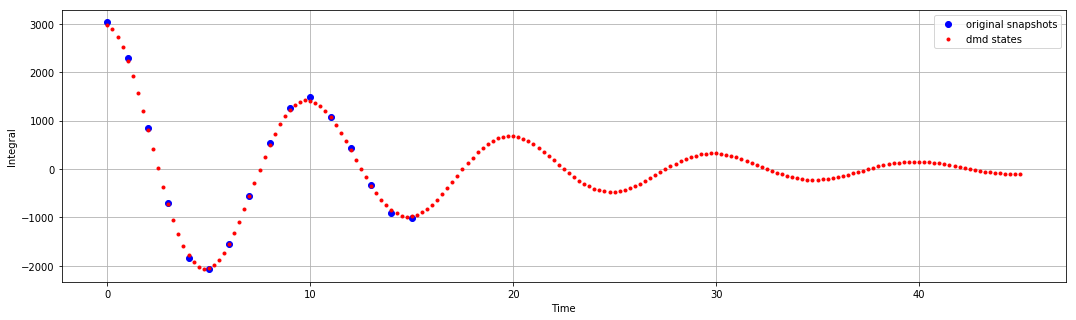

In [8]:
compute_integral = scipy.integrate.trapz

original_int = [compute_integral(compute_integral(snapshot)).real for snapshot in snapshots]
dmd_int = [compute_integral(compute_integral(state)).real for state in dmd_states]

figure = plt.figure(figsize=(18, 5))
plt.plot(dmd.original_timesteps, original_int, 'bo', label='original snapshots')
plt.plot(dmd.dmd_timesteps, dmd_int, 'r.', label='dmd states')
plt.ylabel('Integral')
plt.xlabel('Time')
plt.grid()
leg = plt.legend()


The estimation of the future evolution seems reasonable, but this still be a simple testcase: try to apply the dynamic mode decomposition on more complex systems and share with us your results!